In [ ]:
#1 Importing libraries and Files
import os
import re
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
from pandas import CategoricalDtype
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive')

# Define the directory path for your data
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Final/MDataFiles_Stage2/'
for filename in os.listdir(DATA_PATH):
    print(filename)

df_computer_ranks = pd.read_csv(DATA_PATH + "MMasseyOrdinals_thruDay128.csv")


Mounted at /content/drive
MConferenceTourneyGames.csv
MGameCities.csv
Conferences.csv
Cities.csv
MMasseyOrdinals_thruDay128.csv
MNCAATourneySlots.csv
MNCAATourneyDetailedResults.csv
MSecondaryTourneyCompactResults.csv
MSeasons.csv
MTeamSpellings.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MRegularSeasonCompactResults.csv
MTeamConferences.csv
MNCAATourneySeeds.csv
MNCAATourneyCompactResults.csv
MRegularSeasonDetailedResults.csv
MSampleSubmissionStage2.csv
MNCAATourneySeedRoundSlots.csv
MTeams.csv


In [ ]:
#2 Exploratory Data Analysis / Data Prep
#Seeds
df_seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
df_seeds.head()

#Season Results
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']
df_season_results.head()

#Features

#Wins
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

#Losses
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

#Score Gap Wins
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

#Score Gap Losses
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

#Merge
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season.fillna(0, inplace=True)

#Compute Features
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] -
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)


#Tournamnet Results
df_tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

def get_round(day):
#     round_dic = {134: 0, 135: 0, 136: 1, 137: 1, 138: 2, 139: 2, 143: 3, 144: 3, 145: 4, 146: 4, 152: 5, 154: 6}
    round_dic = {137: 0, 138: 0, 139: 1, 140: 1, 141: 2, 144: 3, 145: 3, 146: 4, 147: 4, 148: 4, 151:5, 153: 5, 155: 6} # probably wrong but I don't use it anyways
    try:
        return round_dic[day]
    except:
        ##print(f'Unknow day : {day}')
        return 0

df_tourney_results['Round'] = df_tourney_results['DayNum'].apply(get_round)
df_tourney_results.head()

df_massey = pd.read_csv(DATA_PATH + "MMasseyOrdinals_thruDay128.csv")
df_massey = df_massey[df_massey['RankingDayNum'] == 133].drop('RankingDayNum', axis=1).reset_index(drop=True) # use first day of the tournament
df_massey.tail()


<ipython-input-2-74fb74e12ec5>:34: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)


,Season,SystemName,TeamID,OrdinalRank
309504,2021,WOB,1467,233
309505,2021,WOB,1468,176
309506,2021,WOB,1469,290
309507,2021,WOB,1470,256
309508,2021,WOB,1471,234


In [ ]:
#3 Featured Engineering
# Train Data
df = df_tourney_results.copy()
df = df[df['Season'] >= 2003].reset_index(drop=True)

df.head()

#Seeds
df = pd.merge(
    df,
    df_seeds,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

df = pd.merge(
    df,
    df_seeds,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

df.tail()
# Season Stats
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

df.tail()


avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()
df = pd.merge(
    df,
    avg_ranking,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankW'})
df = pd.merge(
    df,
    avg_ranking,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankL'})
df.head()

def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA",
        "WScore" : "ScoreA",
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
        "SeedW": "SeedA",
        "SeedL": "SeedB",
        'WinRatioW' : 'WinRatioA',
        'WinRatioL' : 'WinRatioB',
        'GapAvgW' : 'GapAvgA',
        'GapAvgL' : 'GapAvgB',
     }
    lose_rename = {
        "WTeamID": "TeamIdB",
        "WScore" : "ScoreB",
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
        "SeedW": "SeedB",
        "SeedL": "SeedA",
        'GapAvgW' : 'GapAvgB',
        'GapAvgL' : 'GapAvgA',
        'WinRatioW' : 'WinRatioB',
        'WinRatioL' : 'WinRatioA',
    }

    win_df = win_df.copy()
    lose_df = win_df.copy()

    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)

    return pd.concat([win_df, lose_df], 0, sort=False)

df = add_loosing_matches(df)

df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinRatioDiff'] = df['WinRatioA'] - df['WinRatioB']
df['GapAvgDiff'] = df['GapAvgA'] - df['GapAvgB']


df.tail()


<ipython-input-3-7d6c5fc619d1>:66: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()
<ipython-input-3-7d6c5fc619d1>:115: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat([win_df, lose_df], 0, sort=False)


,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,OrdinalRankW,OrdinalRankL,SeedDiff,WinRatioDiff,GapAvgDiff
1176,2021,148,1425,66,1211,85,4,6,1,0.758621,9.655172,1.000000,23.000000,1.037037,16.796296,5,-0.241379,-13.344828
1177,2021,148,1276,49,1417,51,4,1,11,0.833333,10.875000,0.653846,4.346154,45.596154,4.833333,-10,0.179487,6.528846
1178,2021,152,1222,59,1124,78,0,2,1,0.884615,18.000000,0.916667,17.958333,3.074074,5.185185,1,-0.032051,0.041667
1179,2021,152,1417,90,1211,93,0,11,1,0.653846,4.346154,1.000000,23.000000,1.037037,45.596154,10,-0.346154,-18.653846
1180,2021,154,1211,70,1124,86,0,1,1,1.000000,23.000000,0.916667,17.958333,3.074074,1.037037,0,0.083333,5.041667


In [ ]:
#Features
#Wins
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

#Losses
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

#Score Gap Wins
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

#Score Gap Losses
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

#Merge
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season.fillna(0, inplace=True)

#Compute Features
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] -
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

<ipython-input-4-5f9df6f86e82>:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)


In [ ]:
#Tournamnet Results
df_tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

def get_round(day):
#     round_dic = {134: 0, 135: 0, 136: 1, 137: 1, 138: 2, 139: 2, 143: 3, 144: 3, 145: 4, 146: 4, 152: 5, 154: 6}
    round_dic = {137: 0, 138: 0, 139: 1, 140: 1, 141: 2, 144: 3, 145: 3, 146: 4, 147: 4, 148: 4, 151:5, 153: 5, 155: 6} # probably wrong but I don't use it anyways
    try:
        return round_dic[day]
    except:
        ##print(f'Unknow day : {day}')
        return 0

df_tourney_results['Round'] = df_tourney_results['DayNum'].apply(get_round)
df_tourney_results.head()

df_massey = pd.read_csv(DATA_PATH + "MMasseyOrdinals_thruDay128.csv")
df_massey = df_massey[df_massey['RankingDayNum'] == 133].drop('RankingDayNum', axis=1).reset_index(drop=True) # use first day of the tournament
df_massey.tail()
systems = []
for year in range(2003, 2023):
     r = df_massey[df_massey['Season'] == year]
     systems.append(r['SystemName'].unique())

all_systems = list(set(list(np.concatenate(systems))))

common_systems = []
for system in all_systems:
    common = True
    for system_years in systems:
        if system not in system_years:
            common = False
    if common:
        common_systems.append(system)

common_systems

df_massey = df_massey[df_massey['SystemName'].isin(common_systems)].reset_index(drop=True)

In [ ]:
#3 Featured Engineering
# Train Data
df = df_tourney_results.copy()
df = df[df['Season'] >= 2003].reset_index(drop=True)

df.head()

#Seeds
df = pd.merge(
    df,
    df_seeds,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

df = pd.merge(
    df,
    df_seeds,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

df.tail()
# Season Stats
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

df.tail()


avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()
df = pd.merge(
    df,
    avg_ranking,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankW'})
df = pd.merge(
    df,
    avg_ranking,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankL'})
df.head()

def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA",
        "WScore" : "ScoreA",
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
        "SeedW": "SeedA",
        "SeedL": "SeedB",
        'WinRatioW' : 'WinRatioA',
        'WinRatioL' : 'WinRatioB',
        'GapAvgW' : 'GapAvgA',
        'GapAvgL' : 'GapAvgB',
     }
    lose_rename = {
        "WTeamID": "TeamIdB",
        "WScore" : "ScoreB",
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
        "SeedW": "SeedB",
        "SeedL": "SeedA",
        'GapAvgW' : 'GapAvgB',
        'GapAvgL' : 'GapAvgA',
        'WinRatioW' : 'WinRatioB',
        'WinRatioL' : 'WinRatioA',
    }

    win_df = win_df.copy()
    lose_df = win_df.copy()

    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)

    return pd.concat([win_df, lose_df], 0, sort=False)

df = add_loosing_matches(df)

df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinRatioDiff'] = df['WinRatioA'] - df['WinRatioB']
df['GapAvgDiff'] = df['GapAvgA'] - df['GapAvgB']


df.tail()


<ipython-input-6-7d6c5fc619d1>:66: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()
<ipython-input-6-7d6c5fc619d1>:115: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat([win_df, lose_df], 0, sort=False)


,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,OrdinalRankW,OrdinalRankL,SeedDiff,WinRatioDiff,GapAvgDiff
1176,2021,148,1425,66,1211,85,4,6,1,0.758621,9.655172,1.000000,23.000000,NaN,NaN,5,-0.241379,-13.344828
1177,2021,148,1276,49,1417,51,4,1,11,0.833333,10.875000,0.653846,4.346154,NaN,NaN,-10,0.179487,6.528846
1178,2021,152,1222,59,1124,78,0,2,1,0.884615,18.000000,0.916667,17.958333,NaN,NaN,1,-0.032051,0.041667
1179,2021,152,1417,90,1211,93,0,11,1,0.653846,4.346154,1.000000,23.000000,NaN,NaN,10,-0.346154,-18.653846
1180,2021,154,1211,70,1124,86,0,1,1,1.000000,23.000000,0.916667,17.958333,NaN,NaN,0,0.083333,5.041667


In [ ]:
DATA_PATH2 = '/content/drive/MyDrive/Colab Notebooks/Final/MDataFiles_Stage1/'

# Test Data
df_test = pd.read_csv(DATA_PATH2 + "MSampleSubmissionStage1.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))
df_test.head()

#Seeds
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

#Season Stats
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

#Ratings
# df_test = pd.merge(
#     df_test,
#     avg_ranking,
#     how='left',
#     left_on=['Season', 'TeamIdA'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankA'})
# df_test = pd.merge(
#     df_test,
#     avg_ranking,
#     how='left',
#     left_on=['Season', 'TeamIdB'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankB'})

# Differences
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinRatioDiff'] = df_test['WinRatioA'] - df_test['WinRatioB']
df_test['GapAvgDiff'] = df_test['GapAvgA'] - df_test['GapAvgB']
# df_test['OrdinalRankDiff'] = df_test['OrdinalRankA'] - df_test['OrdinalRankB']
df_test.tail()

df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

Epoch 1/50
6/6 [==============================] - 10s 102ms/step - loss: 0.6953 - accuracy: 0.4847 - val_loss: 0.6929 - val_accuracy: 0.5152
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.5039 - val_loss: 0.6941 - val_accuracy: 0.4848
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.5043
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 0.6917 - accuracy: 0.5238 - val_loss: 0.6929 - val_accuracy: 0.5152
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.6938 - accuracy: 0.4961 - val_loss: 0.6929 - val_accuracy: 0.5152
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.6916 - accuracy: 0.5231 - val_loss: 0.6933 - val_accuracy: 0.5065
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.6937 - accuracy: 0.5117 - val_loss: 0.6937 - val_accuracy: 0.4957
Epoch 8/50
6/6 [===========

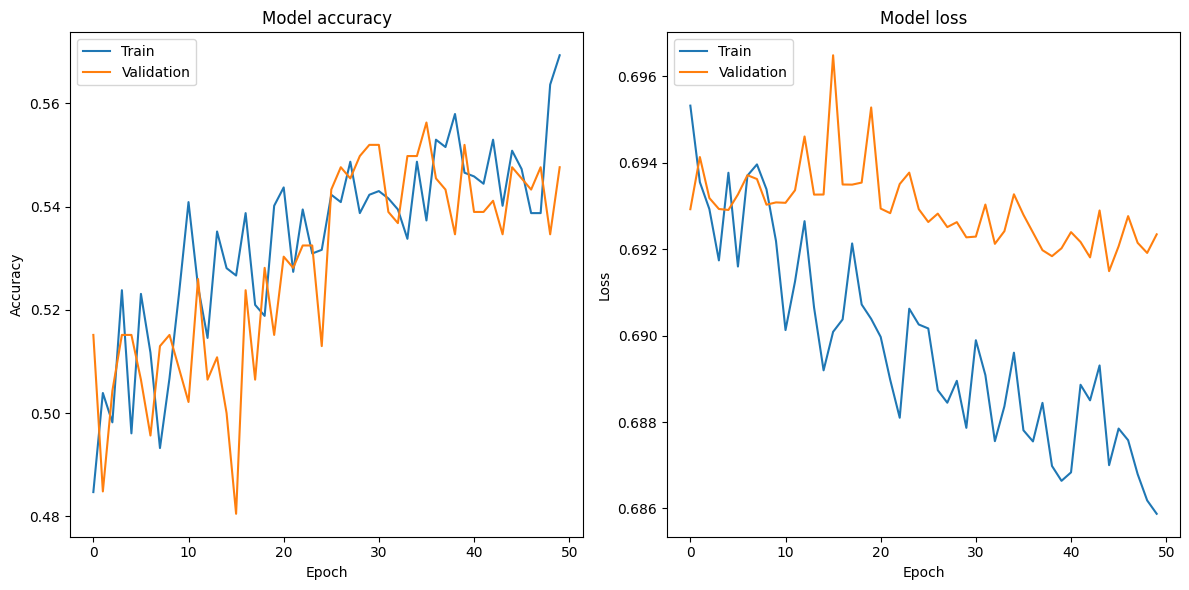

Average Training Accuracy: 0.5337
Average Validation Accuracy: 0.5285


In [ ]:
def rescale(features, df_train, df_val, df_test=None):
    try:
        min_ = df_train[features].min()
        max_ = df_train[features].max()

        df_train.loc[:, features] = (df_train.loc[:, features] - min_) / (max_ - min_)

        if not df_val.empty:
            df_val.loc[:, features] = (df_val.loc[:, features] - min_) / (max_ - min_)

        if df_test is not None:
            df_test.loc[:, features] = (df_test.loc[:, features] - min_) / (max_ - min_)

        return df_train, df_val, df_test
    except KeyError as e:
        print(f"KeyError: {e}")
        print(f"Columns in df_train: {df_train.columns}")
        print(f"Columns in df_val: {df_val.columns}")
        print(f"Columns in df_test: {df_test.columns}")
        raise

# Define features for the RNN
rnn_features = [
    'SeedA', 'SeedB', 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB',
    'SeedDiff', 'WinRatioDiff', 'GapAvgDiff'
]

# Rescale features
df, _, df_test = rescale(rnn_features, df, pd.DataFrame(), df_test)

# Split the data into training, validation, and test sets
df_train, df_val, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

# Rescale features for train, validation, and test sets
df_train, df_val, df_test = rescale(rnn_features, df_train, df_val, df_test)


# Prepare sequences for the RNN
def prepare_sequences(df, sequence_length=10, has_target=True):
    sequences, labels = [], []

    target_column = 'WinA' if has_target else None

    for i in range(len(df) - sequence_length):
        sequences.append(df.iloc[i:i+sequence_length][rnn_features].values)

        if has_target:
            labels.append(df.iloc[i+sequence_length][target_column])

    return np.array(sequences), np.array(labels)

sequence_length = 10  # You can adjust this parameter based on your data

# Use the modified function for training data
X_train, y_train = prepare_sequences(df_train, sequence_length)
X_val, y_val = prepare_sequences(df_val, sequence_length)

# Build the RNN model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, len(rnn_features))))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_val, y_val))

# Make predictions on the test set
X_test, _ = prepare_sequences(df_test, sequence_length, has_target=False)
pred_test = model.predict(X_test)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Calculate average accuracy
avg_train_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
avg_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

print(f'Average Training Accuracy: {avg_train_accuracy:.4f}')
print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}')
